In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True)
valid_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(directory=r'./DATASET/TRAIN',
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(150, 150),
                                                    shuffle=True)


valid_generator = valid_datagen.flow_from_directory(directory=r'./DATASET/TEST',
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)

Found 609 images belonging to 3 classes.
Found 147 images belonging to 3 classes.


In [7]:
labels = []
train_counts = []
for dirname in os.listdir('./DATASET/TRAIN'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('./DATASET/TRAIN',dirname)):
        image_count +=1
    train_counts.append(image_count)
print(labels)
print(train_counts)

['awake', 'phone', 'phoneear']
[203, 200, 206]


In [8]:
class_weights = []
total_samples = train_generator.samples
total_classes = len(train_generator.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))
print(class_weights)

{0: 1.0, 1: 1.01, 2: 0.99}


In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
def custom_model():
    
    
    cus_model = VGG19(input_shape = (150,150,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = layers.Flatten()(cus_model.output)

    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.Dropout(0.2)(x)
 
    x = layers.Dense(3, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [17]:
model = custom_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
39/39 [==============================] - 44s 1s/step - loss: 0.8754 - accuracy: 0.7570 - val_loss: 0.7016 - val_accuracy: 0.7687
Epoch 2/30
39/39 [==============================] - 43s 1s/step - loss: 0.1217 - accuracy: 0.9622 - val_loss: 0.5547 - val_accuracy: 0.7755
Epoch 3/30
39/39 [==============================] - 43s 1s/step - loss: 0.0601 - accuracy: 0.9787 - val_loss: 0.6402 - val_accuracy: 0.7687
Epoch 4/30
39/39 [==============================] - 42s 1s/step - loss: 0.0501 - accuracy: 0.9869 - val_loss: 0.5307 - val_accuracy: 0.8163
Epoch 5/30
39/39 [==============================] - 43s 1s/step - loss: 0.0397 - accuracy: 0.9885 - val_loss: 0.4256 - val_accuracy: 0.8299
Epoch 6/30
39/39 [==============================] - 43s 1s/step - loss: 0.0327 - accuracy: 0.9934 - val_loss: 0.4381 - val_accuracy: 0.8367
Epoch 7/30
39/39 [==============================] - 43s 1s/step - loss: 0.0306 - accuracy: 0.9869 - val_loss: 0.4428 - val_accuracy: 0.8367
Epoch 8/30
39/39 [==

<Figure size 432x288 with 0 Axes>

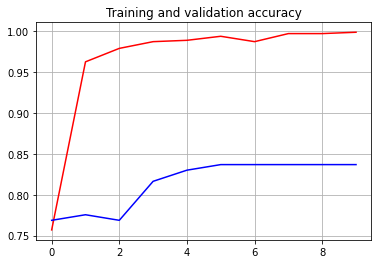

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

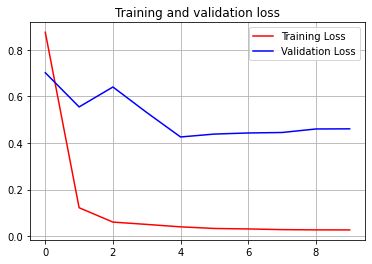

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model.evaluate(valid_generator, batch_size=1)


10/10 [==============================] - 7s 653ms/step - loss: 0.4606 - accuracy: 0.8367


[0.46056070923805237, 0.8367347121238708]

In [24]:
y_pred = model.predict(valid_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(valid_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        50
           1       0.93      0.83      0.88        47
           2       0.75      0.92      0.83        50

    accuracy                           0.84       147
   macro avg       0.85      0.84      0.84       147
weighted avg       0.85      0.84      0.84       147



In [25]:
model.save("FACEDRIVE.h5")


In [26]:
model.save("FACEDRIVEHDF5.hdf5")


In [2]:
model = keras.models.load_model("FACEDRIVE.h5")


In [5]:
img = keras.preprocessing.image.load_img(
    "f2.jpg", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
preds = np.argmax(predictions, axis=1)
score = preds[0]
print(score)


1


In [12]:
import cv2
from PIL import Image


In [14]:
video=cv2.VideoCapture(0)

In [15]:

while True:
        _, frame = video.read()
        
        im = Image.fromarray(frame, 'RGB')

        im = im.resize((150,150))
        img_array = np.array(im)
        img_array = np.expand_dims(img_array, axis=0)       
        predictions = model.predict(img_array)
        preds = np.argmax(predictions, axis=1)
        score = preds[0]
        print(score)
        cv2.imshow("Capturing", frame)
        key=cv2.waitKey(1)
        if key == ord('q'):
                break
video.release()
cv2.destroyAllWindows()


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
2
1
2
1
1
1
1
2
1
2
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
